In [2]:
%cd ~
![ ! -d "./Python_CNN" ] && echo "Github Repo DOES NOT exists."
![ ! -d "./Python_CNN" ] && git clone https://github.com/ShoaibSajid/Python_CNN
![ -d "./Python_CNN" ] && echo "Github Repo exist."
%cd Python_CNN
%pip install -r requirements.txt
# %pip install tensorflow==2.10.0
%pip install keras==2.2.4
!echo 
!echo List of files
!ls

/home/gpuadmin
Github Repo exist.
/home/gpuadmin/Python_CNN
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.

List of files
cnn_keras.py			  conv.py	      python_cnn.py
cnn.py				  data.csv	      README.md
CNN_Python_CIFAR.ipynb		  fc.py		      relu.py
CNN_Python.ipynb		  filters.npy	      requirements.txt
CNN_Python_MNIST_and_CIFAR.ipynb  LICENSE	      soft_fc.py
CNN_Torch.ipynb			  linear_biases.npy   softmax.py
cnn_torch.py			  linear_filters.npy  softmax_test.py
conv_filters_3d.npy		  maxpool.py	      weights
conv_filters.npy		  __pycache__


In [1]:
# Importing libraries

from logging import raiseExceptions
import os
import pickle
from tqdm import tqdm
import numpy as np
from matplotlib import pyplot

In [2]:
# Importing network layers

from conv import Conv3x3, Conv3x3_n_to_n_padding, Conv3x3_1_to_n_padding
from maxpool import MaxPool2
from softmax import Softmax
from relu import Relu
from softmax_test import Softmax_test
from fc import FC

In [3]:
# Importing Dataset

import mnist
from keras.datasets import cifar10
from keras.utils import to_categorical

Using TensorFlow backend.
2022-12-08 12:12:29.129614: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-08 12:12:29.344125: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-12-08 12:12:30.268260: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-08 12:12:30.268342: W tensorflow/compiler/xla/stream_executor/platform/

In [4]:
# Defining Dataset

# Dataset="MNIST" #"CIFAR" #"MNIST"
Dataset="CIFAR" #"CIFAR" #"MNIST"

if Dataset=="MNIST":
  # ====================== MNIST =============================
  # Importing the training dataset - MNIST Dataset
  train_images = mnist.train_images()
  train_labels = mnist.train_labels()
  test_images = mnist.test_images()
  test_labels = mnist.test_labels()
  # Shuffle Data
  permutation = np.random.permutation(len(train_images))
  train_images = train_images[permutation]
  train_labels = train_labels[permutation]
  print(f'Train: {train_images.shape} images and {train_labels.shape} labels.')
  print(f'Test : {test_images.shape } images and {test_labels.shape } labels.')

elif Dataset=="CIFAR":
  # ====================== CIFAR10 ===========================
  (train_images, train_labels), (test_images, test_labels) = cifar10.load_data()
  print('Train: X=%s, y=%s' % (train_images.shape, train_labels.shape))
  print('Test: X=%s, y=%s' % (test_images.shape, test_labels.shape))

Train: X=(50000, 32, 32, 3), y=(50000, 1)
Test: X=(10000, 32, 32, 3), y=(10000, 1)


In [5]:
limit_data=False
data_len=100
if limit_data:
  train_images = train_images[:data_len]
  train_labels = train_labels[:data_len]
  test_images  = test_images[:int(data_len/10)]
  test_labels  = test_labels[:int(data_len/10)]

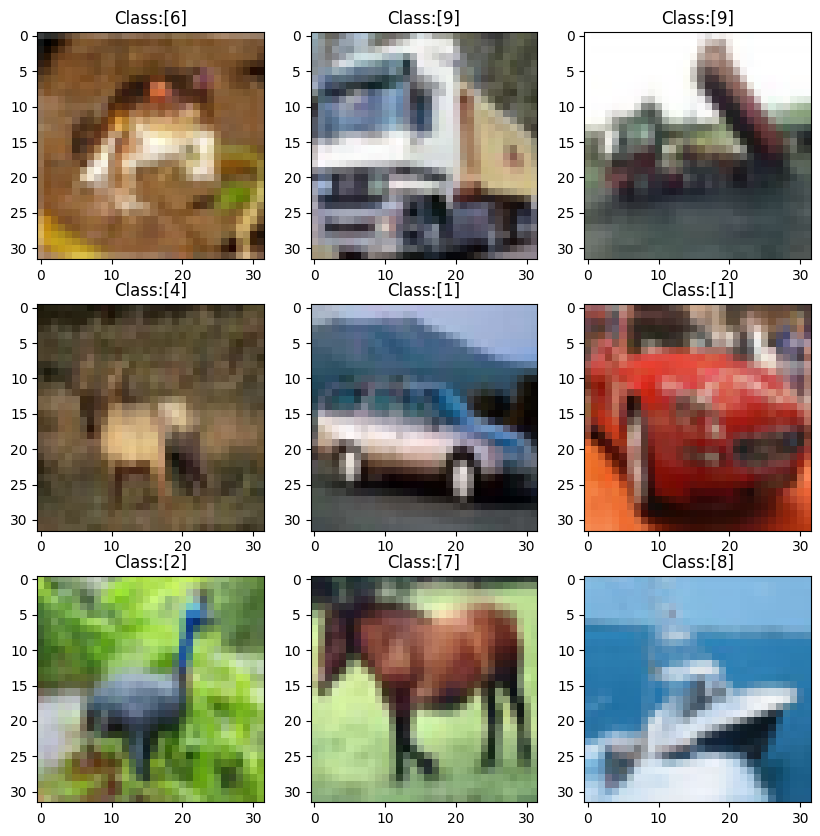

In [6]:
# Plot a few images
pyplot.figure(figsize=(10,10))
for i in range(9):
  pyplot.subplot(330 + 1 + i)
  pyplot.imshow(train_images[i])
  pyplot.title(f'Class:{train_labels[i]}')
pyplot.show()


use_one_hot_encoding=False
if use_one_hot_encoding:
  train_labels = to_categorical(train_labels)
  test_labels = to_categorical(test_labels)

In [7]:
# Define settings for run

debug=False

shuffle_data=False

run_train=False
run_val=True

load_saved_weights=True
weight_file='weights/best_99.pkl'

total_epoch=100
training_acc_internal=1000

In [8]:
# Initialize the network layers

if Dataset=="MNIST":
  conv0   = Conv3x3_1_to_n_padding( output=8                        )     # 28x28x1   -> 28x28x8  (Convolution with 8 filters)
elif Dataset=="CIFAR":
  conv0   = Conv3x3_n_to_n_padding( output=8      ,   input=3       )     # 28x28x1   -> 28x28x8  (Convolution with 8 filters)
pool0   = MaxPool2              (                                 )     # 28x28x8   -> 14x14x8  (MaxPooling 2x2)
conv1   = Conv3x3_n_to_n_padding( output=16     ,   input=8       )     # 14x14x8   -> 14x14x16 (Convolution with 8 filters)
pool1   = MaxPool2              (                                 )     # 14x14x16  -> 07x07x16 (MaxPooling 2x2)
# conv2   = Conv3x3_n_to_n_padding( output=32     ,   input=16      )
# conv3   = Conv3x3_n_to_n_padding( output=64     ,   input=32      )
if Dataset=="MNIST":
  FC_size= 7 * 7 * 16
elif Dataset=="CIFAR":
  FC_size= 8 * 8 * 16
  
fc0     = FC                    (  FC_size ,   FC_size      )     # 784       -> 784      (FC)
fc1     = FC                    (  FC_size ,   10           )     # 784       -> 10       (FC)
softmax = Softmax               (                                 )     # 14x14x8   -> 10       (Softmax)
relu    = Relu                  (                                 )     # 14x14x8   -> 10       (Softmax)

In [9]:
# Defining the network - Forward propagation
def forward(im, label, debug=False):
  im        = (im / 255) - 0.5  
    
  # Conv 0 with Pool
  out_conv0 = conv0.forward   ( im            )
  out_pool0 = pool0.forward   ( out_conv0     )
  
  # Conv 1 with Pool
  out_conv1 = conv1.forward   ( out_pool0     )
  out_pool1 = pool1.forward   ( out_conv1     )
  
  # Swap axes to realign for flattening
  out_pool2 = np.swapaxes(out_pool1,0,2)
  out_pool3 = np.swapaxes(out_pool2,1,2)
  
  # FC0 and Relu
  out_fc0   = fc0.forward     ( out_pool3     )
  
  # FC1 and SoftMax
  out_fc1   = fc1.forward     ( out_fc0       )
  out_soft  = softmax.forward ( out_fc1       )
  
  if debug:
    print(f"Input Image: {im[-4]}\n")
    print(f"x_conv0 filters : {conv0.filters[0]}\n")
    print(f"x_conv0 : {out_conv0[:,:,0][-1]}\n")
    print(f"MaxPool0: {out_pool0[:,:,0][-1]}\n")
    print(f"x_conv1 filters : {conv1.filters[0,:,:,0]}\n")
    print(f"x_conv1 : {out_conv1[:,:,0][-1]}\n")
    print(f"MaxPool1: {out_pool1[:,:,0][-1]}\n")
    print(f"FC0 Weights: {fc0.weights[:,0][:10]}\n")
    print(f"FC0 output: {out_fc0[:10]}\n")
    print(f"FC1 Weights: {fc1.weights[:,0][:10]}\n")
    print(f"FC1 output: {out_fc1[:10]}\n")
    print(f"SoftMax output: {out_soft}\n")

  return out_soft

In [10]:
# Defining the network - Backward propagation
def backward(label, out, loss=1, lr=0.005):
  # Calculate initial gradient
  gradient = np.zeros(10)
  gradient[label] = -1 / out[label]
  # gradient[label] = -loss / out[label]

  # ------------------------------Backprop-----------------------------------
  # SoftMax
  gradient_softmax = softmax.backprop ( gradient                              )     

  # FC1 and FC0 
  gradient_fc1 = fc1.backprop         ( gradient_softmax  ,               lr  )
  gradient_fc0 = fc0.backprop         ( gradient_fc1      ,               lr  )

  # Swap axes to realign for flattening
  gradient_swap0 = np.swapaxes        ( gradient_fc0      ,       1   ,   2   )
  gradient_swap1 = np.swapaxes        ( gradient_swap0    ,       0   ,   2   )

  # Conv 1 with Pool 
  gradient_pool1 = pool1.backprop     ( gradient_swap1                        )
  gradient_conv1 = conv1.backprop     ( gradient_pool1     ,              lr  )

  # Conv 0 with Pool 
  gradient_pool0 = pool0.backprop     ( gradient_conv1                        ) 
  gradient_conv0 = conv0.backprop     ( gradient_pool0     ,              lr  )
  return None

In [11]:
# Defining the network - Loss Function (Cross Entropy)
# Calculate cross-entropy loss and accuracy. np.log() is the natural log.
def cal_loss(out_soft, label):
  loss = -np.log(out_soft[label])
  acc = 1 if np.argmax(out_soft) == label else 0
  return out_soft, loss, acc

In [12]:
# Defining the network - Training Function
def train(im, label, debug=False, lr=.005):
  pred = forward(im, label, debug)
  out_soft, loss, acc = cal_loss(pred, label)
  backward(label, out_soft, loss=loss, lr=0.005)
  return loss, acc

In [13]:
# Defining the network - Validation Function
def val(im, label):
  pred = forward(im, label)
  out_soft, loss, acc = cal_loss(pred, label)
  predLabel = np.argmax(pred)
  return loss, acc, predLabel

In [14]:
# Function definitions to save and load weight files

def save_weights(name,lr=0,max_acc=0):
  print(f"\nSaving new weights ({name}).")
  weights = dict()
  weights["conv0"]        = conv0.filters
  weights["conv1"]        = conv1.filters
  weights["fc0_weights"]  = fc0.weights
  weights["fc0_biases" ]  = fc0.biases
  weights["fc1_weights"]  = fc1.weights
  weights["fc1_biases" ]  = fc1.biases
  weights["lr" ]          = lr
  weights["max_acc"]      = max_acc
  weight_file = open(str(name), "wb")
  pickle.dump(weights, weight_file)
  weight_file.close()
  
def load_weights(name):
  if os.path.isfile(name): 
    weight_file = open(str(name), "rb")
    weights = pickle.load(weight_file)
    conv0.filters  = weights["conv0"]      
    conv1.filters  = weights["conv1"]      
    fc0.weights    = weights["fc0_weights"]
    fc0.biases     = weights["fc0_biases" ]
    fc1.weights    = weights["fc1_weights"]
    fc1.biases     = weights["fc1_biases" ]
    lr             = weights["lr" ]
    max_acc        = weights["max_acc"]
    print(f"\nLoading weights from {name} file. LR restored to {lr}. Last Accuracy {max_acc}%")
    return lr, max_acc
  else:
    print("Weights file not found.")
    lr=0.005
    max_acc=0
    return lr, max_acc
   

In [15]:
# Defining the network - Adjust learning rate
def adjust_lr(acc, lr=.005):
  if   acc > 98: lr=0.00001
  elif acc > 95: lr=0.0005
  elif acc > 90: lr=0.001
  elif acc > 80: lr=0.002
  elif acc > 70: lr=0.003
  elif acc > 60: lr=0.004
  return lr

In [16]:
# Load Weights
if load_saved_weights:
    lr, max_acc = load_weights(weight_file)
else:
    lr, max_acc = 0.005, 0 

if debug: save_weights(f'weights/debug.pkl', lr, max_acc)


Loading weights from weights/best_99.pkl file. LR restored to 0.0005. Last Accuracy 99%


In [17]:
 # Main function to run the training

if run_train:
  print(f'Training Initialized.')
  print(f"\tTotal number of training   images: {len(train_labels)}")
  print(f"\tTotal number of validation images: {len(test_labels)}")
  print(f"\tTraining will run for {total_epoch} epochs.")
  print(f"\tResults will be logged after every {training_acc_internal} images.")
  for epoch in range(total_epoch):
    print('\n--- Epoch %d ---' % (epoch + 1))
            
    # Initialize Variables
    loss, num_correct = 0, 0
    for i, (im, label) in tqdm(enumerate(zip(train_images, train_labels))):
      
      # Logging results
      if i % training_acc_internal == training_acc_internal-1:
        lr = adjust_lr(num_correct)
        print(f'\n[Step {(i+1)}] : For {training_acc_internal} iterations, the Avg Loss is {np.round((loss / training_acc_internal),2)} | Training Acc: {num_correct/training_acc_internal} | LR: {lr}')
        loss, num_correct = 0, 0
          
      # Train the network
      l, acc = train(im, label, debug, lr=lr)
      loss += l
      num_correct += acc
           
    print(f"End of epoch {epoch+1}")      

    print(f"\n\nCalculating validation scores at the end of epoch.")
    loss, num_correct, predLabels, imagesList, gtLabels = 0, 0, [], [], []
    for im, label in tqdm(zip(test_images, test_labels)):
      l, acc, predLabel = val(im, label)
      loss += l
      num_correct += acc
      predLabels.append(predLabel)
      gtLabels.append(label)
      imagesList.append(im)
    num_tests = len(test_images)
    test_loss, test_acc =  loss / num_tests , num_correct / num_tests
    print('Test Loss:', test_loss*100+"%")
    print('Test Accuracy:', test_acc)

    if epoch == 0:
      max_acc = test_acc
    elif test_acc > max_acc: 
      max_acc = test_acc
      save_weights(f'weights/best_{test_acc}.pkl', lr, max_acc)
      save_weights(f'weights/last.pkl', lr, max_acc)

    pyplot.close()
    pyplot.figure(figsize=(10,10))
    for i in range(9):
      pyplot.subplot(330 + 1 + i)
      pyplot.imshow(imagesList[i])
      Str="Correct" if predLabels[i]==gtLabels[i] else "Wrong"
      pyplot.title(f'{Str} -- PD:{predLabels[i]} GT:{gtLabels[i]}')
    pyplot.show()


In [19]:
# Main function to validate the weights

if run_val:
  print(f'\n--- Testing the CNN for {len(test_labels)} images---')
  loss = 0
  num_correct = 0
  for im, label in tqdm(zip(test_images, test_labels)):
    l, acc, predLabel = val(im, label)
    loss += l
    num_correct += acc
    

  num_tests = len(test_images)
  print('\nTest Loss:', loss / num_tests)
  print('Test Accuracy:', num_correct / num_tests)


--- Testing the CNN for 10000 images---


0it [00:00, ?it/s]


IndexError: too many indices for array: array is 3-dimensional, but 4 were indexed